In [1]:
import bson
import csv
import gridfs
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymongo
import scipy.signal
import seaborn as sns
import yaml

from pathlib import Path

%matplotlib inline

In [2]:
creds_path = Path('/home/paperspace/eim-creds.yml')
with open(creds_path, 'r') as stream:
    try:
        creds = yaml.load(stream)
    except yaml.YAMLError as exc:
        print(exc)

In [3]:
client = pymongo.MongoClient(host='eim-data.musicsensorsemotion.com', port=27017, 
                             username=creds['username'], password=creds['password'], 
                             authSource='admin', ssl=True)
db = client.eim

In [4]:
data_root = Path('../../neural_nets/fastai/data')
song = 'into_dust'
song_title = 'Into Dust'

def get_trial_ids_for_song(data_root, song):
    csv_hallelujah = data_root / ('good_' + song + '_trials_and_signals.csv')
    df_hallelujah = pd.read_csv(csv_hallelujah)
    df_hallelujah = df_hallelujah.drop(labels=['Unnamed: 0'], axis=1)
    return df_hallelujah

df_hallelujah = get_trial_ids_for_song(data_root, song)
ids_hallelujah = df_hallelujah._id.values

ids_hallelujah[0:5]

array(['5410f69408ad6ee3090e3881', '5410f69408ad6ee3090e3886',
       '5410f69608ad6ee3090e38a4', '5410f71408ad6ee3090e3aca',
       '5410f7b408ad6ee3090e3d12'], dtype=object)

In [5]:
def get_signal_for_song(db, trial_id, song):
    song_id = db.media.find_one(filter={'title': song})['_id']
    trial_doc = db.trials.find_one(filter={'_id': bson.ObjectId(trial_id)})
    ix = trial_doc['media'].index(song_id)
    signal_id = trial_doc['signals'][ix]
    signal_doc = db.signals.find_one(filter={'_id': bson.ObjectId(signal_id)})
    return signal_doc

In [6]:
signal = get_signal_for_song(db, ids_hallelujah[0], song_title)
signal

{'_id': ObjectId('5410f66c08ad6ee3090e37ef'),
 'label': 'S011',
 'metadata': {'location': 'dublin', 'terminal': 1, 'session_number': 518},
 'data_file': ObjectId('56bb6a469d74e20860099f37'),
 'trial': ObjectId('5410f69408ad6ee3090e3881'),
 'derived_eda_data_file': ObjectId('5704718383a73564c29a5154'),
 'derived_pox_data_file': ObjectId('5704718383a73564c29a5157')}

In [7]:
def get_df_for_signal(db, signal):
    data_file_id = signal['derived_eda_data_file']
    data_file = gridfs.GridFS(db, 'signals').find_one({'_id': data_file_id})
    sc_df = pd.read_csv(data_file)
    sc_df.eda_cleaned = scipy.signal.detrend(sc_df.eda_cleaned)
    return sc_df

In [8]:
signal_df = get_df_for_signal(db, signal)

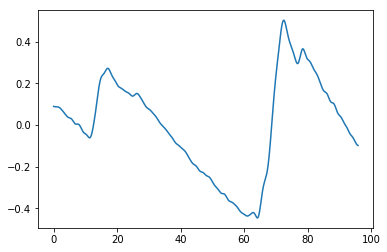

In [9]:
plt.plot(signal_df.adjusted_time, signal_df.eda_cleaned)

In [10]:
def get_df_for_trial_id(db, trial_id, song):
    signal = get_signal_for_song(db, trial_id, song)
    df = get_df_for_signal(db, signal)
    return df

In [11]:
ids_reaction = df_hallelujah[df_hallelujah.critical_reaction == True]._id.values
ids_no_reaction = df_hallelujah[df_hallelujah.critical_reaction == False]._id.values

In [12]:
eda_reaction_dfs = [get_df_for_trial_id(db, i, song_title).drop(labels=['Unnamed: 0'], axis=1) for i in ids_reaction]
eda_reaction_dfs = [df.set_index('adjusted_time') for df in eda_reaction_dfs]

eda_no_reaction_dfs = [get_df_for_trial_id(db, i, song_title).drop(labels=['Unnamed: 0'], axis=1) for i in ids_no_reaction]
eda_no_reaction_dfs = [df.set_index('adjusted_time') for df in eda_no_reaction_dfs]

# eda_dfs = [get_df_for_trial_id(db, i, song_title).drop(labels=['Unnamed: 0'], axis=1) for i in ids_hallelujah[0:5]]
# eda_dfs = [df.set_index('adjusted_time') for df in eda_dfs]

In [13]:
eda_reaction_df = pd.concat([df.eda_cleaned for df in eda_reaction_dfs], axis=1)
eda_no_reaction_df = pd.concat([df.eda_cleaned for df in eda_no_reaction_dfs], axis=1)

In [14]:
eda_reaction_df.head()

,eda_cleaned,eda_cleaned,eda_cleaned,eda_cleaned,eda_cleaned,eda_cleaned,eda_cleaned,eda_cleaned,eda_cleaned,eda_cleaned,...,eda_cleaned,eda_cleaned,eda_cleaned,eda_cleaned,eda_cleaned,eda_cleaned,eda_cleaned,eda_cleaned,eda_cleaned,eda_cleaned
adjusted_time,,,,,,,,,,,,,,,,,,,,,
0.000,-0.226591,NaN,NaN,NaN,NaN,NaN,-0.048316,NaN,NaN,-0.268768,...,-1.252296,NaN,NaN,NaN,NaN,-0.421385,NaN,-0.115176,-0.001385,-1.238997
0.001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,-0.016434,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0.007,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0.009,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,-0.043324,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0.010,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,-0.042493,0.009129,NaN,-0.021861,NaN,NaN,NaN


In [15]:
eda_reaction_df = eda_reaction_df.interpolate(method='nearest')
eda_no_reaction_df = eda_no_reaction_df.interpolate(method='nearest')

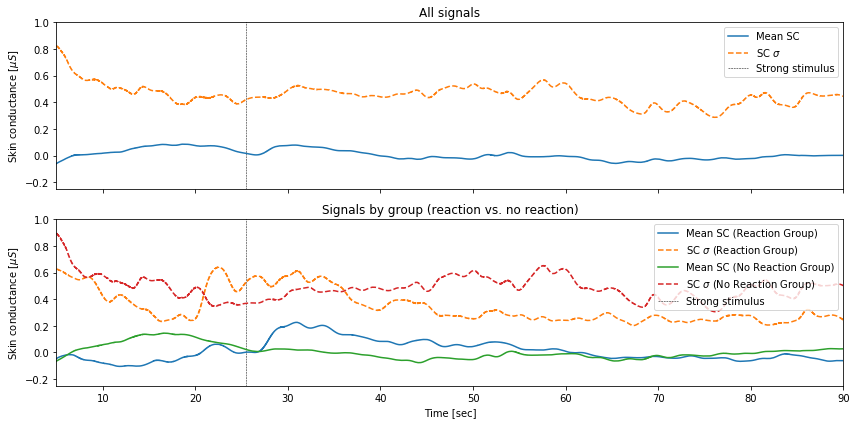

In [19]:
fix, ax = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(12,6))

all_signals_df = pd.concat([eda_reaction_df, eda_no_reaction_df], axis=1)
all_signals_df = all_signals_df.interpolate(method='nearest')

ax[0].plot(all_signals_df.index, all_signals_df.mean(axis=1), label='Mean SC')
ax[0].plot(all_signals_df.index, all_signals_df.std(axis=1), '--', label=r'SC $\sigma$')
ax[0].vlines([25.459], -10, 10, linestyles=['--'], lw=0.5, label='Strong stimulus')
ax[0].set_ylabel(r'Skin conductance [$\mu S$]')
ax[0].set_title('All signals')
ax[0].legend()

ax[1].plot(eda_reaction_df.index, eda_reaction_df.mean(axis=1), label='Mean SC (Reaction Group)')
ax[1].plot(eda_reaction_df.index, eda_reaction_df.std(axis=1), 
           '--', label=r'SC $\sigma$ (Reaction Group)')
ax[1].plot(eda_no_reaction_df.index, eda_no_reaction_df.mean(axis=1), label='Mean SC (No Reaction Group)')
ax[1].plot(eda_no_reaction_df.index, eda_no_reaction_df.std(axis=1), 
           '--', label=r'SC $\sigma$ (No Reaction Group)')
ax[1].vlines([25.459], -10, 10, linestyles=['--'], lw=0.5, label='Strong stimulus')
ax[1].set_xlabel('Time [sec]')
ax[1].set_ylabel(r'Skin conductance [$\mu S$]')
ax[1].set_title('Signals by group (reaction vs. no reaction)')
ax[1].legend()

plt.xlim([5,90])
plt.ylim([-0.25, 1.])

# plt.suptitle('Skin Conductance Signals for Jeff Buckley\'s "Hallelujah"', y=1.025)

plt.tight_layout()
plt.savefig('hallelujah_reaction_into_dust_signals.pdf')